In [1]:
# This notebook tests SPS2 method with the following constraint: Second order Taylor series

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch

%matplotlib inline
import matplotlib
import sklearn
import time
from sklearn.preprocessing import normalize
import math
# from adahessian import AdaHessian

/home/farshed.abdukhakimov/.conda/envs/sps2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib
# import fqs
torch.set_default_dtype(torch.float64)

# Generate data


$f(x) = \frac1n \sum_{i=1}^n \frac12(a_i^Tx-b_i)^2$
suppose $x^*=xo$, $b_i=a_i^Txo$

In [3]:
np.random.seed(0)
n = 1000
d = 20
A = np.random.randn(n,d)
xopt = np.random.randn(d)
b= A @ xopt 
tA = torch.Tensor(A)
tb = torch.Tensor(b)
xopt = torch.Tensor(xopt)

In [4]:
A

array([[ 1.76405235,  0.40015721,  0.97873798, ..., -0.20515826,
         0.3130677 , -0.85409574],
       [-2.55298982,  0.6536186 ,  0.8644362 , ...,  1.20237985,
        -0.38732682, -0.30230275],
       [-1.04855297, -1.42001794, -1.70627019, ...,  0.3024719 ,
        -0.63432209, -0.36274117],
       ...,
       [-0.85259255, -0.1797548 , -0.84311081, ...,  0.62572622,
        -0.59228872, -0.73691532],
       [-0.06113942, -0.49714704,  0.43210231, ..., -0.7888105 ,
         0.20570363,  0.34291633],
       [-0.75590132,  0.9190708 ,  1.53418368, ..., -0.05725925,
        -1.05893126, -0.32652844]])

In [5]:
xopt

tensor([ 3.3005e-01, -4.7998e-04,  8.1812e-01,  4.2821e-01, -2.5039e+00,
         1.2048e-01,  8.0789e-01,  6.0212e-01, -8.6519e-01, -1.5332e-01,
        -2.4049e-01, -6.0763e-02,  5.3287e-01,  7.6440e-01, -8.5608e-01,
        -1.6823e+00,  6.5307e-01,  9.3026e-01,  4.0518e-01,  2.0400e-01])

In [6]:
def fun(At,x,bt):
    return 1/2*torch.mean(torch.norm(At@x-bt)**2)

In [7]:
def dfun(At,x,bt):
    return At.T@(At@x-bt)

# SGD

loss= 14248.9342353893
loss= 4.344033080458574e-06
loss= 7.255037454958109e-16
loss= 4.4434545228429845e-25
loss= 1.715664616778815e-28
loss= 3.424026107208514e-28
loss= 1.7826407565248253e-28
loss= 1.056950353479715e-28
loss= 7.52838311541193e-29
loss= 1.3765314647315554e-28
loss= 5.613238378713262e-29
loss= 1.701351105432129e-28
loss= 2.064138529056353e-28
loss= 1.0166637509030228e-28
loss= 1.6426988349057602e-28
loss= 7.738232442152364e-29
loss= 1.4431224184886885e-28
loss= 1.4287819441227813e-28
loss= 9.717356571603574e-29
loss= 2.4134213319105327e-29
loss= 0.0
loss= 2.3454437085934416e-28
loss= 2.3378825076317764e-28
loss= 1.4493354684892817e-28
loss= 2.8325036878091955e-29
loss= 9.151402798145942e-29
loss= 1.9024181916261563e-28
loss= 2.4134213319105327e-29
loss= 5.265646542350255e-29
loss= 0.0
loss= 1.9006617435168753e-29
loss= 1.843839106437674e-28
loss= 1.6599243523283594e-28
loss= 1.2056321451864096e-28
loss= 1.1840501742296065e-28
loss= 2.730710586528553e-28
loss= 1.23476761

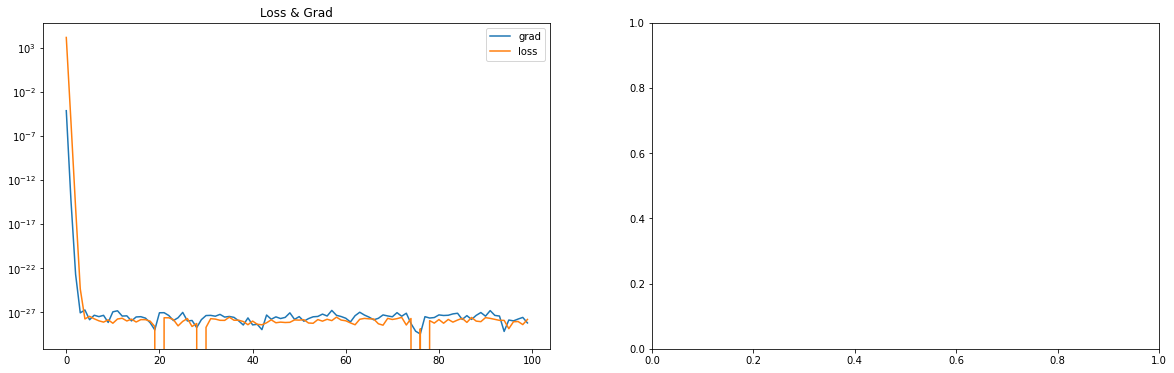

In [9]:
data = torch.utils.data.TensorDataset(tA, tb)
BS = 50
trainloader = torch.utils.data.DataLoader(data, batch_size=BS, shuffle=True)
w = torch.zeros(d, requires_grad=True)
hist_grad=[]
hist_loss=[]
for it in range(100):
    loss=fun(tA,w,tb)
    hist_loss.append(loss.item())    
    print('loss=',loss.item())
    for i,(xx,yy) in enumerate (trainloader):
        # hist_loss.append((1/2*torch.mean(torch.norm(tA@w-tb)**2)).item())    
        # print('loss=',1/2*torch.mean(torch.norm(tA@w-tb)**2))
        loss = fun(xx,w,yy)
        grad_f, = torch.autograd.grad(loss, w, create_graph=True)    
        gd=dfun(xx,w,yy)
        w=w-0.01*grad_f
    hist_grad.append((torch.norm(grad_f)**2).item())
# plt.plot(torch.tensor(hist_loss),label='loss')
# plt.plot(torch.tensor(hist_grad),label='grad')
fig,(ax1,ax2) = plt.subplots(1,2);fig.set_size_inches(20, 6)
ax1.semilogy(torch.tensor(hist_grad),label='grad')
ax1.semilogy(torch.tensor(hist_loss),label='loss')
ax1.title.set_text('Loss & Grad')
ax1.legend()


In [9]:
def diag_estimate(data_shape_cols, grad, weights, iters):
    Ds = []
    for j in range(iters):
        v = torch.rand(d)
        D = torch.autograd.grad( torch.sum(grad*v) , weights, retain_graph=True)    
        D=torch.stack(D,dim=0)
        Ds.append(D*v)

    return torch.mean(torch.stack(Ds), 0)

In [10]:
def diag_estimate1(data_shape_cols, grad, weights, iters):
    Ds = []
    for j in range(iters):
        v = torch.round(torch.rand(d)) * 2 - 1
        D = torch.autograd.grad( torch.sum(grad*v) , weights, retain_graph=True)    
        D = torch.stack(D,dim=0)
        Ds.append(D*v)

    return torch.mean(torch.stack(Ds), 0)

In [11]:
# compute for v (lagrangian mutiplier)
# the inverse of (v*B+D)
def g_v(v,f,gradf,B,D):
    D_inv=torch.linalg.inv(D)
    inv=D_inv-1/(1+v*torch.trace(B@D_inv))*(D_inv@B@D_inv)
    return -v*f+1/2*v**2*torch.dot(gradf,inv@gradf)

In [12]:
def dg_v(v,f,gradf,B,D):
    D_inv=torch.linalg.inv(D)
    a=torch.dot(gradf,D_inv@gradf)
    b=torch.dot(gradf,D_inv@B@D_inv@gradf)
    c=torch.trace(B@D_inv)
    return -f+a*v-b/2*(c*v**2+2*v)/(1+c*v)**2

# SPS

loss= 14248.9342353893
loss= 0.0008344226145675453
loss= 1.6349064291372063e-10
loss= 1.0658962971192813e-17
loss= 6.834577360820205e-25
loss= 1.3554849022992915e-28
loss= 1.6492739597358984e-28
loss= 2.816233431639012e-28
loss= 2.892099664008314e-28
loss= 1.7375277735074991e-28
loss= 2.4618623218717607e-28
loss= 2.7018486003819654e-28
loss= 1.5588631044265836e-28
loss= 3.2519095999385146e-28
loss= 2.737131636963139e-28
loss= 2.6853472326184556e-28
loss= 2.2808711294180263e-28
loss= 3.5651736609727653e-28
loss= 1.8948069164859381e-28
loss= 2.9462105917258175e-28
loss= 2.820732403989101e-28
loss= 2.595968675759333e-28
loss= 2.296263161533568e-28
loss= 2.544939235952848e-28
loss= 2.796712205722703e-28
loss= 4.25747614250198e-28
loss= 2.117968271001976e-28
loss= 2.189597457493626e-28
loss= 2.8784794874416076e-28
loss= 8.736018227740503e-29
loss= 3.644306270527748e-28
loss= 1.93757796869089e-28
loss= 2.433173669420169e-28
loss= 2.9247018061069013e-28
loss= 1.5814812256934675e-28
loss= 2.78

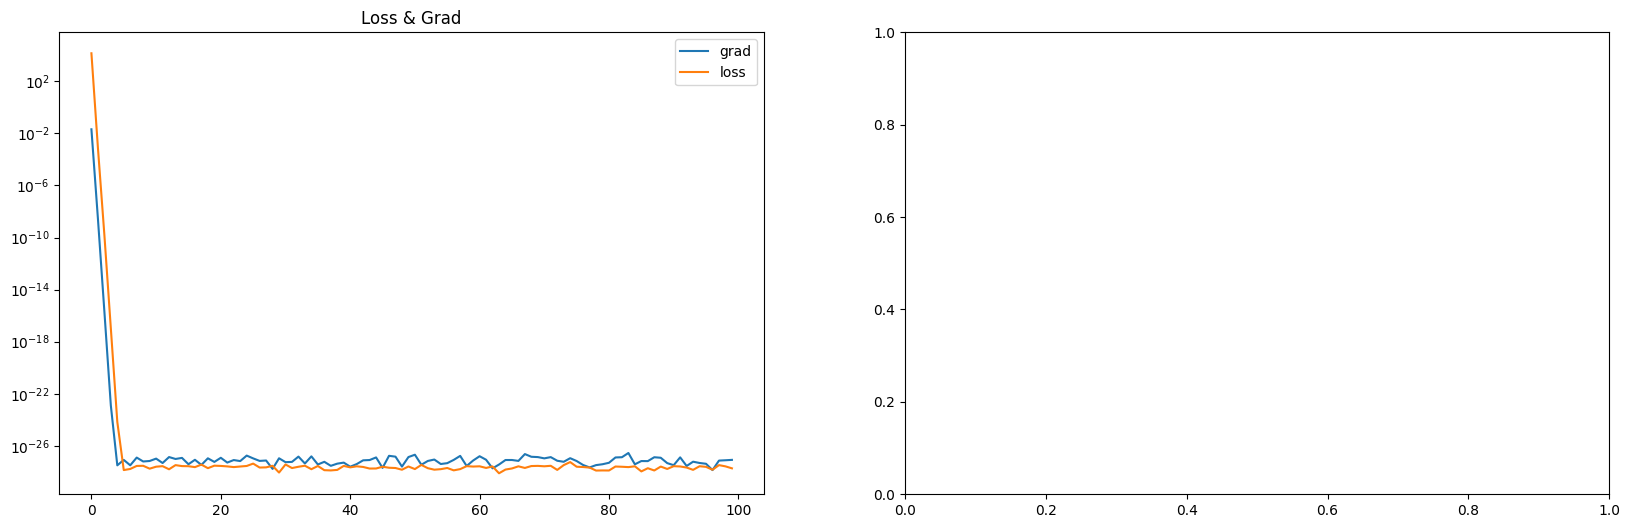

In [13]:
w = torch.zeros(d, requires_grad=True)
hist_grad=[]
hist_loss=[]

for step in range(100):
    loss=fun(tA,w,tb)
    hist_loss.append(loss.item())    
    print('loss=',loss.item())
    for i,(xx,yy) in enumerate(trainloader):
        loss = fun(xx,w,yy)
        grad_f, = torch.autograd.grad(loss, w, create_graph=True)
        # precond = torch.min((loss / (torch.linalg.norm(g) ** 2 + epsilon)), eta)
        precond = loss / (torch.linalg.norm(grad_f) ** 2) 
        w = w - ( precond * grad_f )

    #hist_loss.append(fun(tA,w,tb).item())
    hist_grad.append((torch.norm(grad_f)**2).item()) 
fig,(ax1,ax2) = plt.subplots(1,2);fig.set_size_inches(20, 6)
ax1.semilogy(torch.tensor(hist_grad),label='grad')
ax1.semilogy(torch.tensor(hist_loss),label='loss')
ax1.title.set_text('Loss & Grad')
ax1.legend()

# SPS-D

torch.Size([1, 20])
loss= 14248.9342353893
loss= 11995.06766452509
loss= 9588.700699331008
loss= 7500.825710046813
loss= 5368.835794903757
loss= 3476.3326806704245
loss= 1549.3854014822225
loss= 15.59404427161522
loss= 210.83068396073062
loss= 46.72853967073647
loss= 25.473369572591906
loss= 46.67569088521682
loss= 253.0540967150968
loss= 20.6377101620081
loss= 35.80435595812661
loss= 185.50198559764254
loss= 5.078718934536944
loss= 14.398265159818262
loss= 23.356935903804874
loss= 182.75528254509408
loss= 13.151632951948859
loss= 246.13494869667417
loss= 26.04440299719487
loss= 6.890061700081105
loss= 23.14809348670025
loss= 13.225747657267556
loss= 47.40753996021292
loss= 14.10619260864967
loss= 65.43623089480032
loss= 67.67892751610162
loss= 3.9364689763740346
loss= 120.38162735648096
loss= 121.44575536012451
loss= 19.30691782689201
loss= 11.62814280389116
loss= 28.960863058340106
loss= 4.986316723583485
loss= 54.25113612129372
loss= 7.80276209309569
loss= 108.07320070612938
loss= 1

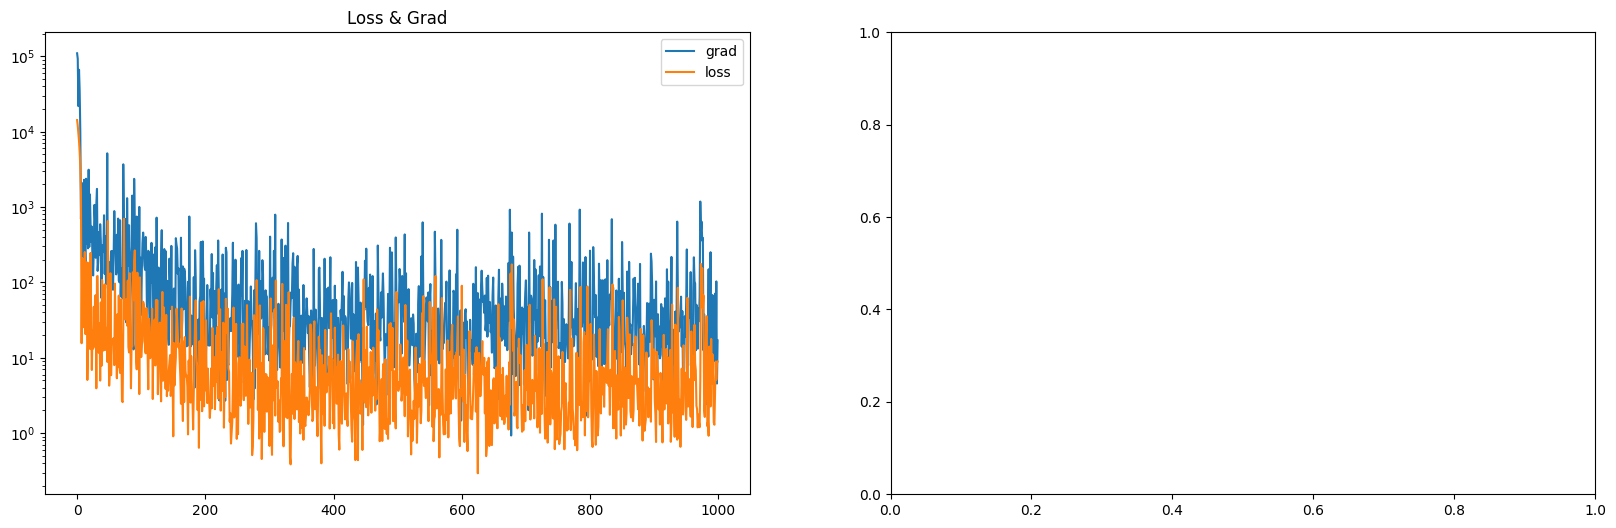

In [18]:
w = torch.zeros(d, requires_grad=True)
alpha = 1e-1
beta = 0.999

data = torch.utils.data.TensorDataset(tA, tb)
BS = 50
trainloader = torch.utils.data.DataLoader(data, batch_size=BS, shuffle=True)

loss=fun(tA,w,tb)
grad_f, = torch.autograd.grad(loss, w, create_graph=True)
hist_grad=[]
hist_loss=[]
# Ds = []
# for j in range(100):
#     z = rademacher(train_data.shape[1]).to(device=device)
#     hvp = torch.autograd.grad(g,  w,  grad_outputs = z, retain_graph = True)[0]
#     Ds.append( (hvp*z) ) 

# Dk = torch.mean(torch.stack(Ds), 0)

Dk = diag_estimate1(d, grad_f, w, 100)
print(Dk.shape)
for step in range(1000):
    loss=fun(tA,w,tb)
    print('loss=',loss.item())
    hist_loss.append(loss.item())    
    grad_f, = torch.autograd.grad(loss, w, create_graph=True) 

    # print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2).item()}")

    
    for i,(xx,yy) in enumerate (trainloader):
        #print('loss=',lgstc(X,y,w).item())
        loss = fun(xx,w,yy)

        grad_f, = torch.autograd.grad(loss, w, create_graph=True)
            
        #print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2).item()}")

        # if i%1 == 0: print(f"Accuracy: {np.mean(trainX.dot(w.cpu().data.numpy())*trainY > 0)}")

        vk = diag_estimate1(d, grad_f, w, 1)

        # print(vk)

        # Smoothing and Truncation        
        Dk = beta * Dk + (1 - beta) * vk
        Dk_hat = torch.abs(Dk)
        Dk_hat[Dk_hat < alpha] = alpha


        Dk_hat_inv = 1 / Dk_hat
        # print(torch.norm(Dk_hat_inv).item(), torch.norm(w).item() , torch.norm(g).item() , loss.item() )
        gnorm = ((grad_f * Dk_hat_inv).flatten()).dot(grad_f)
        #print(gnorm)
        if gnorm.item() < 1e-13:
            continue
        precond = (loss / (gnorm ** 2)) * Dk_hat_inv
        
        with torch.no_grad():
            w.sub_((precond * grad_f).flatten())
    hist_grad.append((torch.norm(grad_f) ** 2).item())

fig,(ax1,ax2) = plt.subplots(1,2);fig.set_size_inches(20, 6)
ax1.semilogy(torch.tensor(hist_grad),label='grad')
ax1.semilogy(torch.tensor(hist_loss),label='loss')
ax1.title.set_text('Loss & Grad')
ax1.legend()

loss= 14248.9342353893
302512458734428.06 -1646234370498277.2 -3249782373.99776 -1604.3646054466094
coeffienct (A=2.710090551908828e+30,B=5.349907808777133e+24, C=2.6376050094551685e+18)
DET= 9.639966415723925e+45
v= 5.441874938196126
155720989401103.75 -895409602731140.6 -1770507513.8095438 -871.3802580840764
coeffienct (A=8.017591837786845e+29,B=1.5853306508024665e+24, C=7.939701042995871e+17)
DET= -1.1006006232628226e+46
v1= -1.0546164663796396e-06
v2= 5.7500913273434415
v3= -9.227653354046495e-07
v1v2v3= 5.595779101040698e-12
v= 5.7500913273434415
24715427809280.418 -243150426719086.28 -466721745.4792404 -223.69816342298375
coeffienct (A=5.912216461935657e+28,B=1.1348364133151637e+23, C=5.465227602546566e+16)
DET= -1.5368863380044546e+43
v1= -1.008604450707629e-06
v2= 9.838003858807708
v3= -9.121503255305013e-07
v1v2v3= 9.050952512300319e-12
v= 9.838003858807708
23702792390733.78 -146479340651688.56 -302707582.1664569 -155.32872456095376
coeffienct (A=2.145621876279835e+28,B=4.4340

/tmp/ipykernel_532296/1343726560.py:113: RuntimeWarning: invalid value encountered in double_scalars
  v1= -cc/bb


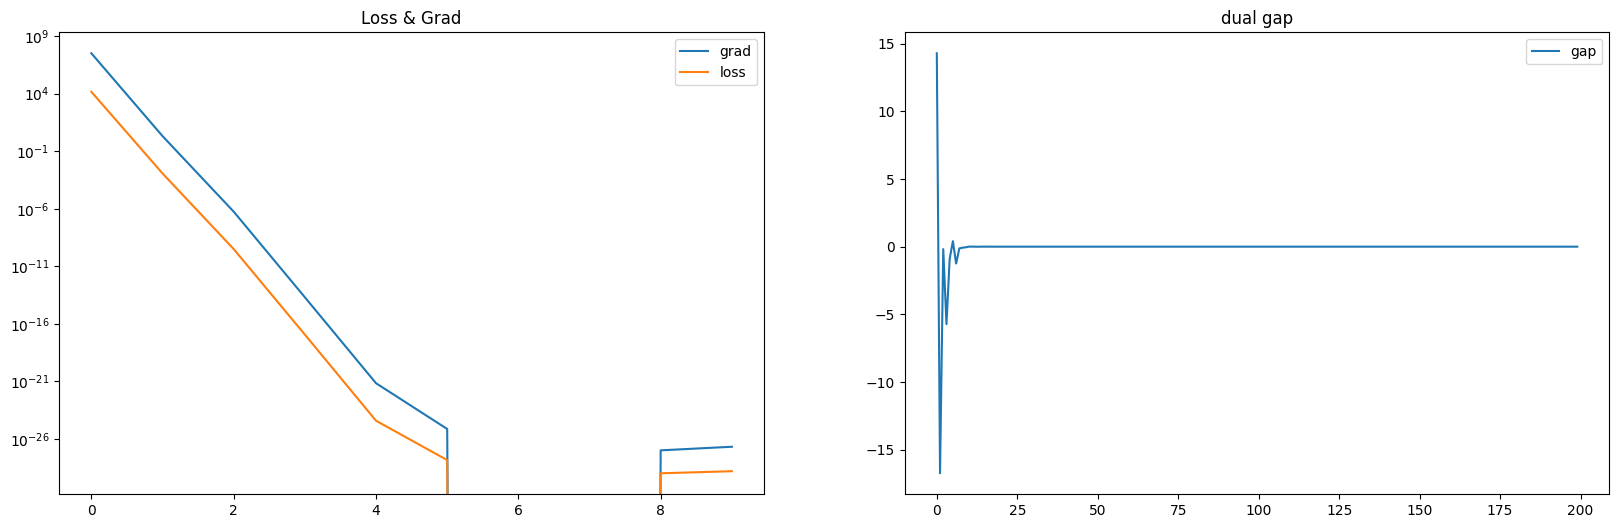

In [20]:
# sk = torch.ones(d,1)
w = torch.zeros(d, requires_grad=True)
#w1 = torch.zeros(d,1).double()
fvalN = []
data = torch.utils.data.TensorDataset(tA, tb)
BS = 50
trainloader = torch.utils.data.DataLoader(data, batch_size=BS, shuffle=True)
#H = d2lgstc(X,y,np.array(w1),lmd)
#H1=torch.diag(H,0)
#print(H1)
loss = fun(tA,w,tb)
grad_f, = torch.autograd.grad(loss, w, create_graph=True)

#print(torch.norm(Dk-H1))
alpha = 1e-4
beta = 0.999
v=torch.zeros(1,requires_grad=True)
gamma=0.01
hist_d=[]
hist_gap=[]
hist_grad=[]
hist_gradd=[]
hist_loss=[]
Dk = diag_estimate1(d, grad_f, w, 100)
Dk_hat = torch.abs(Dk)
Dk_hat[Dk_hat < alpha] = alpha
D=torch.diagflat(Dk_hat)


#print(B)
for it in range(10):
    loss=fun(tA,w,tb)
    print('loss=',loss.item())
    hist_loss.append(loss.item())    
    grad_f, = torch.autograd.grad(loss, w, create_graph=True) 
    hist_d.append((torch.norm(grad_f)**2).item())
    #hist_grad.append(grad_f)  
    
    
    #print('prime=',0.5*torch.dot(dk,D@dk))
    #print('dual=',-g_v(v,loss.item(),grad_f,B,D))
    
    
    
    
    for i,(xx,yy) in enumerate (trainloader):
        # print('loss=',fun(tA,w,tb).item())
        loss = fun(xx,w,yy)
        # print('sampleloss=',loss.item())
        # hist_loss.append(loss.item())   
        grad_f, = torch.autograd.grad(loss, w, create_graph=True) 
        #print(grad_f)
        hist_gradd.append(grad_f)
        
# generate random vector sk from unit sphere
        sk= torch.randn(d,1)
        sk=sk/sk.norm()

        vk = diag_estimate1(d, grad_f, w, 1)
        Dk = beta * Dk + (1 - beta) * vk
        Dk_hat = torch.abs(Dk)
        Dk_hat[Dk_hat < alpha] = alpha

        D=torch.diagflat(Dk_hat)
        
        yk=D@sk
        B=yk.T*yk/sk.T*yk
        
        # 
        # D=torch.diagflat(Dk_hat)

        # print(Dk_hat)
        # print(torch.norm(Dk_hat-H1))
        
        # this is much faster for find the lagrangian multiplier
        #st=time.time()
        D_inv=torch.linalg.inv(D)
        a=torch.dot(grad_f,D_inv@grad_f)
        a=a.detach().numpy()
        b=torch.dot(grad_f,D_inv@B@D_inv@grad_f)
        b=b.detach().numpy()
        c=torch.trace(B@D_inv)
        c=c.detach().numpy()

        aa=2*a*c**2
        bb=4*a*c-2*c**2*loss.item()-b*c
        cc=2*a-2*b-4*c*loss.item()
        dd=-2*loss.item()

        print(aa,bb,cc,dd)
        # print('-d/a=', -d/a)
        AA=bb*bb-3*aa*cc
        if abs(AA) < 1e-14: AA=0
        BB=bb*cc-9*aa*dd
        if abs(BB) < 1e-14: BB=0
        CC=cc*cc-3*bb*dd
        if abs(CC) < 1e-14: CC=0
        DET=-18*aa*bb*cc*dd+4*bb**3*dd+4*aa*cc**3+27*aa**2*dd**2-bb**2*cc**2
        print("coeffienct (A={},B={}, C={})".format(AA,BB,CC))
        if abs(DET)< 1e-14:
            DET=0
        print('DET=',DET)
        # print('det=',-18*a*b*c*d+4*b**3*d+4*a*c**3+27*a**2*d**2-b**2*c**2)
        third = 1./3.
        sqr3 = math.sqrt(3)
        if DET>0:
            Y1=np.cbrt(AA*bb+1.5*aa*(-BB+math.sqrt(DET)))
            Y2=np.cbrt(AA*bb+1.5*aa*(-BB-math.sqrt(DET)))
            v=(-bb-Y1-Y2)/(3*aa)
        
        elif DET==0:
            if (AA==0)&(BB==0):
                v1= -cc/bb
                v2 = v1
                v3 = v1
                
            if (AA!=0)&(BB!=0):
                K=(bb*cc-9*aa*dd)/(bb*bb-3*aa*cc)
                K=round(K,14)
                v1= -bb/aa + K
                v2= -0.5*K
                v3=v2
            
        elif DET<0:
            sqA=math.sqrt(AA)
            T=(AA*bb-1.5*aa*BB)/(AA**(3/2))
            # print('T=',T)
            if -1< T <1 : 
                T=T
            else:
                T=1
            # print('T=',T)
            theta=math.acos(T)
            csth=math.cos(theta/3)
            snth=sqr3*math.sin(theta/3)
            v1=(-bb-2*sqA*csth)/(3*aa)
            v2=(-bb+sqA*(csth+snth))/(3*aa)
            v3=-dd/aa/v1/v2
            print('v1=',v1)
            print('v2=',v2)
            print('v3=',v3)
            print('v1v2v3=',v1*v2*v3)
            v1=np.max([v1,v2,v3])
            v3=np.min([v1,v2,v3])
            #v1=torch.tensor(v1,dtype=torch.float64)
            #v3=torch.tensor(v3,dtype=torch.float64)
            if v3<0:
                v=v1
            else:
                if g_v(v1,loss.item(),grad_f,B,D)>g_v(v3,loss.item(),grad_f,B,D):
                    print('gv1=',g_v(v1,loss.item(),grad_f,B,D))
                    print('gv3=',g_v(v3,loss.item(),grad_f,B,D))
                    v=v3
                else:
                    v=v1
        


        

        #p=np.array([a,b,c,d])
        #p=np.array([2*c*2 ,(4*a-2*c*2*loss.item()-b)/a,(2*a-2*b-4*c*loss.item())/a*c,(-2*loss.item())/a*c ])

        #p=np.array([1 ,(4*a*c-b*c-2*c**2*loss.item())/2*a*c**2, (2*a-2*b-4*c*loss.item())/2*a*c**2, -loss.item()/a*c**2 ])
        #p=np.array([a ,(4*a*c-b*c-2*c**2*loss.item())/2*c**2, (2*a-2*b-4*c*loss.item())/2*c**2, -loss.item()/c**2 ])

        #print(p)
        #roots = fqs.cubic_roots(p)
        #print(roots)
        #print('time=:', time.time() - st)

        #arg=torch.argmin(torch.tensor([g_v(torch.tensor(roots[0][0].real),loss.item(),grad_f,B,D),g_v(torch.tensor(roots[0][1].real),loss.item(),grad_f,B,D),g_v(torch.tensor(roots[0][2].real),loss.item(),grad_f,B,D)]))
        #print('arg=',arg)
        
        
        #v=roots[0][0].real
        print('v=',v)
        #print('prime=', -g_v(v,loss.item(),grad_f,B,D))
        
        D_inv=torch.linalg.inv(D)
        dk=v*(D_inv-1/(1+v*torch.trace(B@D_inv))*(D_inv@B@D_inv))@grad_f
        w=w-dk
        #hist_g.append(0.5*torch.dot(dk,D@dk))
        
        #print('dual=',0.5*torch.dot(dk,D@dk))
        #print(-g_v(v,loss.item(),grad_f,B,D))
        hist_gap.append(0.5*torch.dot(dk,D@dk)+g_v(v,loss.item(),grad_f,B,D))

fig,(ax1,ax2) = plt.subplots(1,2);fig.set_size_inches(20, 6)
ax1.semilogy(torch.tensor(hist_d),label='grad')
ax1.semilogy(torch.tensor(hist_loss),label='loss')
ax1.title.set_text('Loss & Grad')
ax1.legend()
ax2.plot(torch.tensor(hist_gap),label='gap')
ax2.title.set_text('dual gap')
ax2.legend()

In [21]:
w

tensor([ 0.1644,  0.2248, -3.5159,  0.4204, -0.3749,  0.3374, -0.4104,  0.2001,
         0.3023, -1.1248, -1.4284, -0.6655,  1.1863, -0.5691,  0.7205, -1.6708,
        -0.8384,  1.5804, -0.7533, -0.6955], grad_fn=<SubBackward0>)

In [22]:
torch.norm((w-xopt)**2)

tensor(1.5135e-32, grad_fn=<CopyBackwards>)

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import mpmath
sys.modules['sympy.mpmath'] = mpmath
import sympy

import torch
import numpy as np

from torch.utils.data import DataLoader
import torch.utils.data as data_utils

import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

from datasets import get_dataset

from loss_fns import get_loss

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def logistic_reg(w, X, y):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))

def nllsq(w, X, y):
    return torch.mean( ( y - (1/(1 + torch.exp(-X @ w ))) )**2 )

def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)

In [7]:
# CUBIC ROOT SOLVER

# Date Created   :    24.05.2017
# Created by     :    Shril Kumar [(shril.iitdhn@gmail.com),(github.com/shril)] &
#                     Devojoyti Halder [(devjyoti.itachi@gmail.com),(github.com/devojoyti)]

# Project        :    Classified 
# Use Case       :    Instead of using standard numpy.roots() method for finding roots,
#                     we have implemented our own algorithm which is ~10x faster than
#                     in-built method.

# Algorithm Link :    www.1728.org/cubic2.htm

# This script (Cubic Equation Solver) is an independent program for computation of roots of Cubic Polynomials. This script, however,
# has no relation with original project code or calculations. It is to be also made clear that no knowledge of it's original project 
# is included or used to device this script. This script is complete freeware developed by above signed users, and may further be
# used or modified for commercial or non-commercial purpose.


# Libraries imported for fast mathematical computations.
import math
import numpy as np

# Main Function takes in the coefficient of the Cubic Polynomial
# as parameters and it returns the roots in form of numpy array.
# Polynomial Structure -> ax^3 + bx^2 + cx + d = 0

def solve(a, b, c, d):

    if (a == 0 and b == 0):                     # Case for handling Liner Equation
        return np.array([(-d * 1.0) / c])                 # Returning linear root as numpy array.

    elif (a == 0):                              # Case for handling Quadratic Equations

        D = c * c - 4.0 * b * d                       # Helper Temporary Variable
        if D >= 0:
            D = math.sqrt(D)
            x1 = (-c + D) / (2.0 * b)
            x2 = (-c - D) / (2.0 * b)
        else:
            D = math.sqrt(-D)
            x1 = (-c + D * 1j) / (2.0 * b)
            x2 = (-c - D * 1j) / (2.0 * b)
            
        return np.array([x1, x2])               # Returning Quadratic Roots as numpy array.

    f = findF(a, b, c)                          # Helper Temporary Variable
    g = findG(a, b, c, d)                       # Helper Temporary Variable
    h = findH(g, f)                             # Helper Temporary Variable

    if f == 0 and g == 0 and h == 0:            # All 3 Roots are Real and Equal
        if (d / a) >= 0:
            x = (d / (1.0 * a)) ** (1 / 3.0) * -1
        else:
            x = (-d / (1.0 * a)) ** (1 / 3.0)

        return np.array([x, x, x])              # Returning Equal Roots as numpy array.

    elif h <= 0:                                # All 3 roots are Real

        i = math.sqrt(((g ** 2.0) / 4.0) - h)   # Helper Temporary Variable
        j = i ** (1 / 3.0)                      # Helper Temporary Variable
        k = math.acos(-(g / (2 * i)))           # Helper Temporary Variable
        L = j * -1                              # Helper Temporary Variable
        M = math.cos(k / 3.0)                   # Helper Temporary Variable
        N = math.sqrt(3) * math.sin(k / 3.0)    # Helper Temporary Variable
        P = (b / (3.0 * a)) * -1                # Helper Temporary Variable

        x1 = 2 * j * math.cos(k / 3.0) - (b / (3.0 * a))
        x2 = L * (M + N) + P
        x3 = L * (M - N) + P

        return np.array([x1, x2, x3])           # Returning Real Roots as numpy array.

    elif h > 0:                                 # One Real Root and two Complex Roots
        R = -(g / 2.0) + math.sqrt(h)           # Helper Temporary Variable
        if R >= 0:
            S = R ** (1 / 3.0)                  # Helper Temporary Variable
        else:
            S = (-R) ** (1 / 3.0) * -1          # Helper Temporary Variable
        T = -(g / 2.0) - math.sqrt(h)
        if T >= 0:
            U = (T ** (1 / 3.0))                # Helper Temporary Variable
        else:
            U = ((-T) ** (1 / 3.0)) * -1        # Helper Temporary Variable

        x1 = (S + U) - (b / (3.0 * a))
        x2 = -(S + U) / 2 - (b / (3.0 * a)) + (S - U) * math.sqrt(3) * 0.5j
        x3 = -(S + U) / 2 - (b / (3.0 * a)) - (S - U) * math.sqrt(3) * 0.5j

        # return np.array([x1, x2, x3])           # Returning One Real Root and two Complex Roots as numpy array.
        return np.array([x1, 0, 0])


# Helper function to return float value of f.
def findF(a, b, c):
    return ((3.0 * c / a) - ((b ** 2.0) / (a ** 2.0))) / 3.0


# Helper function to return float value of g.
def findG(a, b, c, d):
    return (((2.0 * (b ** 3.0)) / (a ** 3.0)) - ((9.0 * b * c) / (a **2.0)) + (27.0 * d / a)) /27.0


# Helper function to return float value of h.
def findH(g, f):
    return ((g ** 2.0) / 4.0 + (f ** 3.0) / 27.0)

$\min \frac{1}{2} \| w - w^t \|^2_D \\ 
s.t. \quad f_i + \langle \nabla f_i, w - w^t \rangle + \frac{1}{2} \langle B(w-w^t), (w-w^t) \rangle = 0 $

In [19]:
# training 
STEPS = 100
loss_class = get_loss("logreg")


# dataset
batch_size = 1
dataset_name = "colon-cancer"
percentage = 1.0
scale_range = None # [-value, value]
train_data, train_target = get_dataset(dataset_name, batch_size, percentage, scale_range, loss_class.y_range)
train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)

# parameters
alpha=0.1
beta=0.999
w = torch.zeros(train_data.shape[1], dtype=torch.float64, device=device).requires_grad_()

loss_function = loss_class(w)

# save loss and grad size to history
hist_sps_d = []
loss = loss_function(train_data.to(device).to(torch.float64), train_target.to(device).to(torch.float64)) 
g, = torch.autograd.grad(loss, w, create_graph=True)
print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
hist_sps_d.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

# preconditioninig matrix
Dk = diag_estimate_old(w, g, 100)
print("Dk norm: ", torch.linalg.norm(Dk))


for step in range(STEPS):

    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        batch_data = batch_data.to(device).to(torch.float64)
        batch_target = batch_target.to(device).to(torch.float64)

        loss = loss_function(batch_data, batch_target)
        gk = g.clone().detach()
        g, = torch.autograd.grad(loss, w, create_graph=True)
        g_delta = g - gk

    
        vk = diag_estimate_old(w, g, 1)

        print(f"g_norm_l2: {torch.linalg.norm(g)}")

        # Smoothing and Truncation 
        Dk = beta * Dk + (1 - beta) * vk
        Dk_hat = torch.abs(Dk)
        Dk_hat[Dk_hat < alpha] = alpha

        Dk_hat_inv = 1 / Dk_hat

        sk = torch.randn(batch_data.shape[1], dtype=torch.float64, device=device)
        # yk = torch.autograd.functional.hvp(loss_function, sk)
        yk, = torch.autograd.grad(g, w, grad_outputs=sk)
        yk_norm = torch.linalg.norm(yk)

        print(f"yk norm: {yk_norm}")

        if yk_norm < 1e-10 or torch.isnan(yk_norm):
            continue

        B = ((yk.reshape(-1, 1) @ yk.reshape(1, -1)) / (yk.dot(sk))).to(dtype=torch.float64)

        gnorm = (g * Dk_hat_inv).dot(g)

        print(f"D_hat_inv: {torch.linalg.norm(Dk_hat_inv)}")
        print(f"g_norm_D: {gnorm}")

        if gnorm < 1e-12:
            continue

        f_grad = g.clone().detach().to(dtype=torch.float64)
        D_inv = torch.diagflat(Dk_hat_inv.clone().detach()).to(dtype=torch.float64)
        a = torch.dot(f_grad, D_inv@f_grad).to(dtype=torch.float64)
        b = torch.dot(f_grad, D_inv@B@D_inv@f_grad).to(dtype=torch.float64)
        c = torch.trace(B@D_inv).to(dtype=torch.float64)

        if torch.linalg.norm(f_grad) < 1e-12:
            continue

        print("loss: ", loss)
        print(f"f_grad norm: {torch.linalg.norm(f_grad)}")
        print(f"D_inv norm: {torch.linalg.norm(D_inv)}")
        print(f"B norm: {torch.linalg.norm(B)}") 
        print(f"a: {a}")
        print(f"b: {b}")
        print(f"c: {c}") 

        AA = (2 * a * c ** 2).detach().cpu().numpy()
        BB = (4 * a * c - 2 * loss * c**2 - b * c).detach().cpu().numpy()
        CC = (2 * a - 4 * c * loss - 2 * b).detach().cpu().numpy()
        DD = (- 2 * loss).detach().cpu().numpy()
        
        print(f"plms: {AA} {BB} {CC} {DD}")

        def lagr(lmd):
            b = lambda l: D_inv - (D_inv @ (l * B) @ D_inv) / (1 + torch.trace((l * B) @ D_inv))
            return lmd * loss -  (1/2)*lmd**2 * torch.dot(f_grad, b(lmd)@f_grad)

        lmds = solve(AA, BB, CC, DD)

        # lmd = sympy.Symbol('lmd')
        # expr = AA * lmd**3 + BB * lmd**2 + CC * lmd + DD
        # lmds = sympy.solve(expr)

        print("lmds: ", lmds)
        
        lmd_max = np.maximum(np.max(lmds), torch.tensor(0))
        lmd_max = torch.tensor(lmd_max, dtype=torch.float64, device=device).reshape(1)

        lmd_min = np.maximum(np.min(lmds), torch.tensor(0))
        lmd_min = torch.tensor(lmd_min, dtype=torch.float64, device=device).reshape(1)

        print(f"lmd_max: {lmd_max}, lmd_min: {lmd_min}")

        lmd_star = lmd_max
        print("lmd_star 1: ", lmd_star)
        if lmd_min > 0 and lagr(lmd_max) < lagr(lmd_min):
            lmd_star = lmd_min
        print("lmd_star 2: ", lmd_star)

        print("D_inv norm: ", torch.linalg.norm(D_inv))
        print("B norm: ", torch.linalg.norm(B))
        print("lmd_star: ", lmd_star)

        
        precond = lmd_star * (D_inv - (D_inv @ (lmd_star * B) @ D_inv) / (1 + torch.trace((lmd_star * B) @ D_inv)))

        print("Precond norm: ", torch.linalg.norm(precond))
        print("==================")

        with torch.no_grad():
            w.sub_(precond @ g)

    

    loss = loss_function(train_data.to(device).to(torch.float64), train_target.to(device).to(torch.float64))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist_sps_d.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])


/home/farshed.abdukhakimov/projects/sps2/datasets
Loss: 0.6931471805599453 | GradNorm^2: 25.480627894208755
Dk norm:  tensor(17.0638, device='cuda:0', dtype=torch.float64)
g_norm_l2: 23.480871674484938
yk norm: 662.7077438736083
D_hat_inv: 257.8698209098789
g_norm_D: 2562.9620529092554
loss:  tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
f_grad norm: 23.480871674484938
D_inv norm: 257.8698209098789
B norm: 551.3513345936288
a: 2562.9620529092554
b: 6568774.484652822
c: 2562.9620529092545
plms: 33671039476.567455 -16818350895.372658 -13139529.08488325 -1.3862943611198906
lmds:  [ 5.00270144e-01 -7.79937910e-04 -1.05519886e-07]
lmd_max: tensor([0.5003], device='cuda:0', dtype=torch.float64), lmd_min: tensor([0.], device='cuda:0', dtype=torch.float64)
lmd_star 1:  tensor([0.5003], device='cuda:0', dtype=torch.float64)
lmd_star 2:  tensor([0.5003], device='cuda:0', dtype=torch.float64)
D_inv norm:  tensor(257.8698, device='cuda:0', dtype=torch.float64)
B nor

/tmp/ipykernel_4045360/101860013.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lmd_max = torch.tensor(lmd_max, dtype=torch.float64, device=device).reshape(1)
/tmp/ipykernel_4045360/101860013.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lmd_min = torch.tensor(lmd_min, dtype=torch.float64, device=device).reshape(1)


loss:  tensor(0.5785, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
f_grad norm: 20.289372475039656
D_inv norm: 257.977619394025
B norm: 525.4859025126791
a: 1982.6427008726073
b: 5017793.10448088
c: 2530.8610080234994
plms: 25398673828.91969 -12686676806.341005 -10037477.479313642 -1.1570283265377317
lmds:  [ 5.00291478e-01 -7.89818223e-04 -1.15287632e-07]
lmd_max: tensor([0.5003], device='cuda:0', dtype=torch.float64), lmd_min: tensor([0.], device='cuda:0', dtype=torch.float64)
lmd_star 1:  tensor([0.5003], device='cuda:0', dtype=torch.float64)
lmd_star 2:  tensor([0.5003], device='cuda:0', dtype=torch.float64)
D_inv norm:  tensor(257.9776, device='cuda:0', dtype=torch.float64)
B norm:  tensor(525.4859, device='cuda:0', dtype=torch.float64)
lmd_star:  tensor([0.5003], device='cuda:0', dtype=torch.float64)
Precond norm:  tensor(129.0006, device='cuda:0', dtype=torch.float64)
g_norm_l2: 17.122080446842546
yk norm: 677.56176010045
D_hat_inv: 258.31275555479584
g_norm_D:

TypeError: '>=' not supported between instances of 'NoneType' and 'int'

In [12]:
a = torch.asarray([[1, 2], [4, 3]])
b = torch.asarray([[2, 5, 3], [0, 1, 4]])
c = torch.asarray([[1, 0], [2, 2]])

d = torch.asarray([[1, 2, 3]])
e = torch.asarray([[3, 5, 1]])


d.mul(d.T)

tensor([[1, 2, 3],
        [2, 4, 6],
        [3, 6, 9]])

In [7]:
A = torch.eye(3)
q = torch.asarray([1., 2., 3.])
z = torch.asarray([2., 2., 3.])

A, A.shape, q, q.shape

(tensor([[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]),
 torch.Size([3, 3]),
 tensor([1., 2., 3.]),
 torch.Size([3]))

In [8]:
z - A @ q 

tensor([1., 0., 0.])

In [9]:
ys = (z - A @ q).reshape(-1, 1)

ys @ ys.T

tensor([[1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [10]:
qq = torch.asarray([[1, 2, 3]])

qq, qq.shape

(tensor([[1, 2, 3]]), torch.Size([1, 3]))

In [11]:
gg = g.clone().detach()
ss = torch.randn(batch_data.shape[1], dtype=torch.float64, device=device)

(gg * ss)

tensor([-0.0918, -0.1069, -0.0032,  ...,  0.0029, -0.1239,  0.1123],
       device='cuda:0', dtype=torch.float64)

In [12]:
def F_torch(w):
        return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))

In [13]:
w = torch.randn(train_data.shape[1], device=device).requires_grad_()
v = torch.randn(train_data.shape[1], device=device)

def closure(w):
    loss_function = loss_class(w)
    return loss_function(train_data.to(device), train_target.to(device))

loss = closure(w)
# hvp, = torch.autograd.grad(g, w, grad_outputs=v)

In [14]:
hess_torch = torch.autograd.functional.hessian(closure, w)

In [15]:
# %%timeit
hvp, = torch.autograd.grad(g, w, grad_outputs=v, retain_graph=True)

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [ ]:
# %%timeit
Hvp_torch = torch.autograd.functional.hvp(closure, w, v)[1]

In [ ]:
# %%timeit
Hvp_torch_2 = torch.autograd.functional.vhp(closure, w, v)[1].T

In [ ]:
torch.abs(Hvp_torch.sum() - Hvp_torch_2.sum().item()) 

tensor(7.4506e-09, device='cuda:0')

In [ ]:
# np.abs(Hvp.sum() - Hvp_torch.sum().item()) < SMALL
torch.abs(hvp.sum() - Hvp_torch.sum().item()) 

tensor(7.4506e-09, device='cuda:0')

$\min \frac{1}{2} \| w - w^t \|^2_D \\ 
s.t. \quad f_i + \langle \nabla f_i, w - w^t \rangle + \frac{1}{2} \langle B(w-w^t), (w-w^t) \rangle = 0 $

In [16]:
# training 
STEPS = 100
loss_class = get_loss("logreg")

# dataset
batch_size = 16
dataset_name = "mushrooms"
percentage = 1.0
scale_range = None # [-value, value]
train_data, train_target = get_dataset(dataset_name, batch_size, percentage, scale_range, loss_class.y_range)
train_data = train_data.to(torch.get_default_dtype())
train_target = train_target.to(torch.get_default_dtype())
train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)

# parameters
alpha = 1e-4
beta=0.999
w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

loss_function = loss_class(w)

# save loss and grad size to history
hist_sps_d = []
loss = loss_function(train_data.to(device), train_target.to(device))
g, = torch.autograd.grad(loss, w, create_graph=True)
print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
hist_sps_d.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

# preconditioninig matrix
Dk = diag_estimate_old(w, g, 10)
print("Dk norm: ", torch.linalg.norm(Dk))

print(f"w-x: {torch.abs(torch.sum(w) - torch.sum(xopt))}")

for step in range(STEPS):

    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)

        loss = loss_function(batch_data, batch_target)
        g, = torch.autograd.grad(loss, w, create_graph=True)
    
        vk = diag_estimate_old(w, g, 1)

        # print(f"g_norm_l2: {torch.linalg.norm(g)}")   

        # Smoothing and Truncation 
        Dk = beta * Dk + (1 - beta) * vk
        Dk_hat = torch.abs(Dk)
        Dk_hat[Dk_hat < alpha] = alpha

        Dk_hat_inv = 1 / Dk_hat

        sk = torch.randn((batch_data.shape[1], 1), device=device)
        sk= sk / sk.norm()
        # yk, = torch.autograd.grad(g, w, grad_outputs=sk)
        yk = torch.diagflat(Dk_hat) @ sk
        yk_norm = torch.linalg.norm(yk)

        # print(f"yk norm: {yk_norm}")

        if torch.isnan(yk_norm):
            continue

        # B = ((yk.reshape(-1, 1) @ yk.reshape(1, -1)) / (yk.dot(sk)))
        B = yk.T * yk / (sk.T @ yk)

        gnorm = (g * Dk_hat_inv).dot(g)

        # print(f"D_hat_inv: {torch.linalg.norm(Dk_hat_inv)}")
        # print(f"g_norm_D: {gnorm}")

        # if gnorm < 1e-15:
        #     continue

        f_grad = g.clone().detach()
        D_inv = torch.diagflat(Dk_hat_inv.clone().detach())

        a = torch.dot(f_grad, D_inv@f_grad)
        a = a.cpu().detach().numpy()

        b = torch.dot(f_grad, D_inv@B@D_inv@f_grad)
        b = b.cpu().detach().numpy() 

        c = torch.trace(B@D_inv)
        c = c.cpu().detach().numpy()

        # if torch.linalg.norm(f_grad) < 1e-8:
        #     continue

        # print("loss: ", loss)
        # print(f"f_grad norm: {torch.linalg.norm(f_grad)}")
        # print(f"D_inv norm: {torch.linalg.norm(D_inv)}")
        # print(f"B norm: {torch.linalg.norm(B)}") 
        # print(f"a: {a}")
        # print(f"b: {b}")
        # print(f"c: {c}") 

        AA = 2 * a * c ** 2
        BB = 4 * a * c - 2 * loss.item() * c**2 - b * c
        CC = 2 * a - 4 * c * loss.item() - 2 * b
        DD = - 2 * loss.item()

        
        BB = BB / AA
        CC = CC / AA
        DD = DD / AA

        AA = torch.tensor(1.0)
        
        # print(f"plms: {AA} {BB} {CC} {DD}")

        def lagr(lmd):
            b = lambda l: D_inv - (D_inv @ (l * B) @ D_inv) / (1 + torch.trace((l * B) @ D_inv))
            return lmd * loss -  (1/2)*lmd**2 * torch.dot(f_grad, b(lmd)@f_grad)

        lmds = solve(AA, BB, CC, DD)
        lmds = torch.from_numpy(lmds).to(device)
            
        # print("lmds: ", lmds)
        
        lmd_max = torch.max(lmds)
        lmd_min = torch.maximum(torch.min(lmds), torch.tensor(0))

        # print(f"lmd_max: {lmd_max}, lmd_min: {lmd_min}")

        lmd_star = lmd_max
        if lagr(lmd_max) < lagr(lmd_min):
            lmd_star = lmd_min

        # print("lmd_star 2: ", lmd_star)

        # print("D_inv norm: ", torch.linalg.norm(D_inv))
        # print("B norm: ", torch.linalg.norm(B))
        # print("lmd_star: ", lmd_star)
        
        precond = lmd_star * ((D_inv - (1 / (1 + lmd_star * torch.trace(B @ D_inv))) * (D_inv @ (lmd_star * B) @ D_inv) ))

        # print("Precond norm: ", torch.linalg.norm(precond))
        # print("==================")

        with torch.no_grad():
            w.sub_(precond  @ f_grad)

    loss = loss_function(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist_sps_d.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

print(f"w-x: {torch.abs(torch.sum(w) - torch.sum(xopt))}")

/home/farshed.abdukhakimov/projects/sps2/datasets
Loss: 0.6931471805599454 | GradNorm^2: 0.3195669607542957
Dk norm:  tensor(1.2351, device='cuda:0')
w-x: 0.6755426433049205
Loss: 0.03555294490561396 | GradNorm^2: 0.000580568727899756
Loss: 0.003684802247198842 | GradNorm^2: 6.867250700358725e-06
Loss: 0.007757956071311118 | GradNorm^2: 5.860315870659724e-05
Loss: 0.0026929791866434154 | GradNorm^2: 9.302474918216288e-06
Loss: 0.0023991831940701944 | GradNorm^2: 1.1014190456571182e-05
Loss: 0.0007882460628125505 | GradNorm^2: 3.1760866100762934e-06
Loss: 0.0017656464424613831 | GradNorm^2: 1.0517360920909722e-05
Loss: 0.00018724801907859804 | GradNorm^2: 4.0549136880977054e-07
Loss: 0.00018028426096711807 | GradNorm^2: 3.800829137791337e-07
Loss: 0.00021123718587867313 | GradNorm^2: 4.585567238663337e-07
Loss: 0.0005663879440984218 | GradNorm^2: 1.4780627853295872e-06
Loss: 0.0003102904687333758 | GradNorm^2: 7.377749904425623e-07
Loss: 0.000378114972759007 | GradNorm^2: 9.363460853205

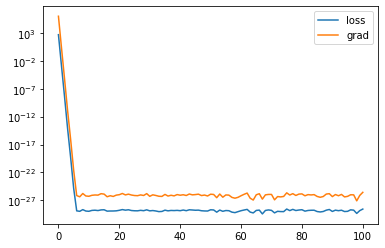

In [38]:
plt.semilogy([x[0] for x in hist_sps_d], label="loss")
plt.semilogy([x[1] for x in hist_sps_d], label="grad")
plt.legend()
plt.show()

$\min \frac{1}{2} \| w - w^t \|^2_B \\ 
s.t. \quad f_i + \langle \nabla f_i, w - w^t \rangle + \frac{1}{2} \langle B(w-w^t), (w-w^t) \rangle = 0 $

In [18]:
# training 
STEPS = 20
loss_class = get_loss("logreg")


# dataset
batch_size = 16
dataset_name = "mushrooms"
percentage = 1.0
scale_range = None # [-value, value]
train_data, train_target = get_dataset(dataset_name, batch_size, percentage, scale_range, loss_class.y_range)
train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)

# parameters
w = torch.zeros(train_data.shape[1], dtype=torch.float64, device=device).requires_grad_()

loss_function = loss_class(w)

# save loss and grad size to history
hist_sps_d = []
loss = loss_function(train_data.to(device).to(torch.float64), train_target.to(device).to(torch.float64)) 
g, = torch.autograd.grad(loss, w, create_graph=True)
print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
hist_sps_d.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])


for step in range(STEPS):

    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        batch_data = batch_data.to(device).to(torch.float64)
        batch_target = batch_target.to(device).to(torch.float64)

        loss = loss_function(batch_data, batch_target)
        gk = g.clone().detach()
        g, = torch.autograd.grad(loss, w, create_graph=True)
        g_delta = g - gk

        print(f"g_norm_l2: {torch.linalg.norm(g)}")


        sk = torch.randn(batch_data.shape[1], dtype=torch.float64, device=device)
        yk, = torch.autograd.grad(g, w, grad_outputs=sk)
        yk_norm = torch.linalg.norm(yk)

        print(f"yk norm: {yk_norm}")

        if yk_norm < 1e-10 or torch.isnan(yk_norm):
            continue

        B = ((sk.reshape(-1, 1) @ sk.reshape(1, -1)) / (yk.dot(sk))).to(dtype=torch.float64)

        gnorm = (g @ B).dot(g)

        print(f"g_norm: {gnorm}")

        if gnorm < 1e-12:
            continue

        f_grad = g.clone().detach().to(dtype=torch.float64)
        
        if torch.linalg.norm(f_grad) < 1e-12:
            continue

        print("loss: ", loss)
        print(f"f_grad norm: {torch.linalg.norm(f_grad)}")
        print(f"B norm: {torch.linalg.norm(B)}") 

        lmd = sympy.Symbol('lmd')
        expr = (2 * loss - gnorm) * lmd ** 2 + (4 * loss - 2 * gnorm) * lmd + 2 * loss
        lmds = sympy.solve(expr)
        print(f"lmds: {lmds}")
        lmd_1 = lmds[0]
        lmd_2 = lmds[1]

        print(lmd_1, type(lmd_1))

        lmd_star = torch.maximum(torch.tensor(0), torch.maximum(lmd_1, lmd_2))        
        print("lmd_max: ", lmd_star)

        # precond = lmd_star * (D_inv - (D_inv @ (lmd_star * B) @ D_inv) / (1 + torch.trace((lmd_star * B) @ D_inv)))
        precond = lmd_star/(1 + lmd_star) * B 

        print("Precond norm: ", torch.linalg.norm(precond))
        print("==================")

        with torch.no_grad():
            w.sub_(precond @ g)

    

    loss = loss_function(train_data.to(device).to(torch.float64), train_target.to(device).to(torch.float64))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
    hist_sps_d.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])


/home/farshed.abdukhakimov/projects/sps2/datasets
Loss: 0.6931471805599453 | GradNorm^2: 25.480627894208755
g_norm_l2: 20.69306094515359
yk norm: 110.33770038095659
g_norm: 1.0000000000000004
loss:  tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
f_grad norm: 20.69306094515359
B norm: 70.83156658122064
lmds: [-1.0 - 1.60894358184558*I, -1.0 + 1.60894358184558*I]
-1.0 - 1.60894358184558*I <class 'sympy.core.add.Add'>


TypeError: maximum(): argument 'input' (position 1) must be Tensor, not Add